In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
from scikitplot.metrics import plot_roc
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

import keras
import tensorflow as tf
from keras import models, layers, optimizers, callbacks, regularizers, initializers

2024-06-28 12:12:40.450973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('./dataset_preprocessed/tabular/no_outliers_tracks.csv')

In [3]:
X = df.drop(columns=[
    'id',
    'name',
    'disc_number',
    'explicit',
    'artists',
    'album_type',
    'album_name',
    'album_release_date',
    'album_release_date_precision',
    'key',
    'mode',
    'time_signature',
    'genre']).values

y = df['explicit'].values.astype(int)

# Logistic Regression

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [75]:
# Calculate class weights
class_weight = {0: (1/np.sum(y_train == 0)) * len(y_train),
                1: (1/np.sum(y_train == 1)) * len(y_train)}

sample_weight = np.array([class_weight[y] for y in y_train])

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
%%time

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty':['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'],
}

grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    cv=KFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_train_scaled, y_train, sample_weight=sample_weight)
log_regress_clf = grid_search.best_estimator_

In [8]:
log_regress_clf

LogisticRegression(C=0.001, penalty='l1', solver='saga')

In [77]:
log_regress_clf = LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=100, random_state=42)
log_regress_clf.fit(X_train_scaled, y_train, sample_weight=sample_weight)

LogisticRegression(C=0.001, penalty='l1', random_state=42, solver='saga')

#### Performances

In [78]:
y_pred = log_regress_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     16242
           1       0.22      0.73      0.34      1545

    accuracy                           0.75     17787
   macro avg       0.59      0.74      0.59     17787
weighted avg       0.90      0.75      0.80     17787



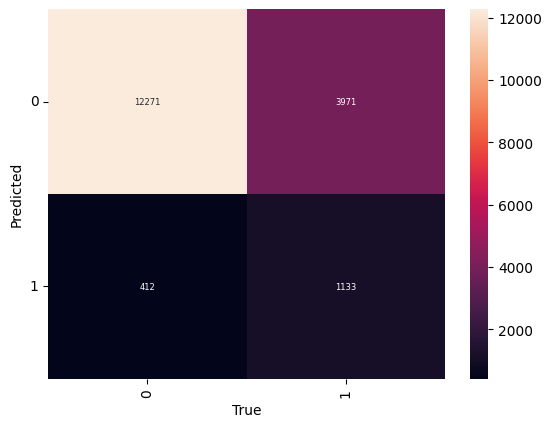

In [79]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/Advanced Classification/logreg_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

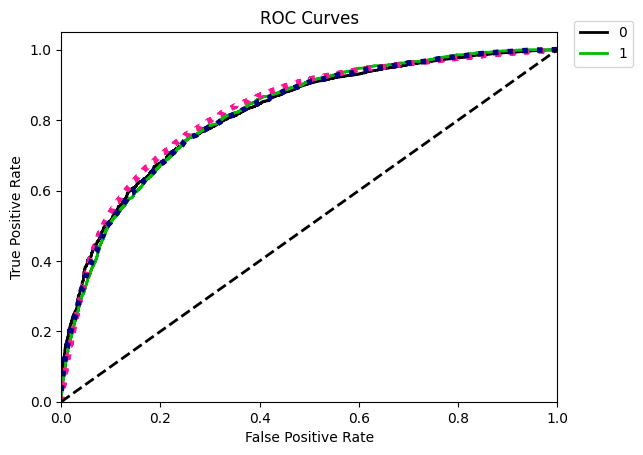

In [80]:
y_test_pred_proba = log_regress_clf.predict_proba(X_test_scaled) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/Advanced Classification/logreg_roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()

# SVM

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [82]:
# Calculate class weights
class_weight = {0: (1/np.sum(y_train == 0)) * len(y_train),
                1: (1/np.sum(y_train == 1)) * len(y_train)}

sample_weight = np.array([class_weight[y] for y in y_train])

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear SVM

In [84]:
clf = LinearSVC(random_state=42, penalty='l2', C=0.001)
clf.fit(X_train, y_train, sample_weight=sample_weight)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.001, random_state=42)

In [85]:
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.49      0.63     16242
           1       0.09      0.51      0.15      1545

    accuracy                           0.49     17787
   macro avg       0.50      0.50      0.39     17787
weighted avg       0.84      0.49      0.59     17787



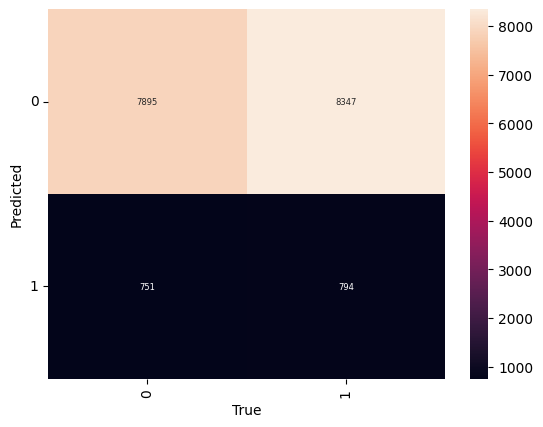

In [86]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/Advanced Classification/svm_linear_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

## Non-linerar SVM

In [87]:
clf = SVC(gamma='auto', C=0.01, kernel='sigmoid', random_state=42)
clf.fit(X_train_scaled, y_train, sample_weight=sample_weight)

SVC(C=0.01, gamma='auto', kernel='sigmoid', random_state=42)

In [88]:
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     16242
           1       0.16      0.67      0.26      1545

    accuracy                           0.68     17787
   macro avg       0.56      0.67      0.53     17787
weighted avg       0.89      0.68      0.75     17787



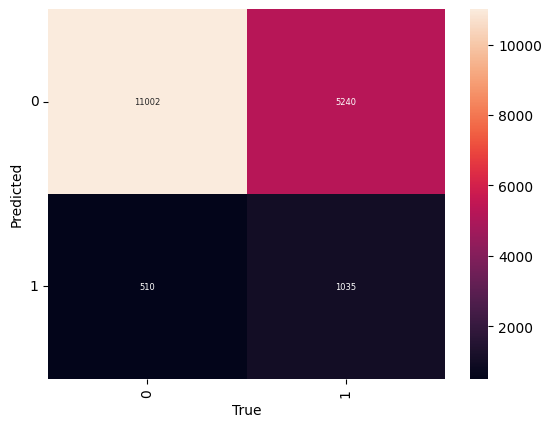

In [89]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/Advanced Classification/svm_nonlinear_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

# Neural Network

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2, 
                                                  random_state=0, 
                                                  shuffle=True, 
                                                  stratify=y_train)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
def my_nn(hidden_layers, activation, lr, reg_type, reg_penalty=0.01, momentum=0):
    model = models.Sequential()

    model.add(keras.layers.Input(shape=(15,)))
    for layer_size in hidden_layers:
        model.add(layers.Dense(units=layer_size,
                               activation=activation,
                               kernel_regularizer=reg_type(reg_penalty)))

    # Output layer
    model.add(layers.Dense(units=1,
                           activation='sigmoid',
                           kernel_regularizer=reg_type(reg_penalty)))
    
    optimizer=optimizers.SGD(learning_rate=lr, momentum=momentum)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,        
        metrics=['accuracy']
    )
    return model

In [19]:
nn = my_nn(hidden_layers=[64, 128, 64],
           activation='relu',
           lr=0.005,
           reg_type=regularizers.l2,
           reg_penalty=0.01,
           momentum=0.5,
           )

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, verbose=True)
mc = callbacks.ModelCheckpoint('best_model_NOREG.keras', monitor='val_loss', save_best_only=True)

tf.random.set_seed(1)
# Calculate class weights
class_weight = {0: (1/np.sum(y_train == 0)) * len(y_train) / 2.0,
                 1: (1/np.sum(y_train == 1)) * len(y_train) / 2.0}
history = nn.fit(X_train_scaled,
       y_train,
       epochs=1000,
       batch_size=2048,
       shuffle=True,
       class_weight=class_weight,
       validation_data=(X_val_scaled, y_val),
       callbacks=[es, mc])

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5267 - loss: 2.6588 - val_accuracy: 0.6025 - val_loss: 2.6452
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6194 - loss: 2.6211 - val_accuracy: 0.6622 - val_loss: 2.6058
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6693 - loss: 2.5869 - val_accuracy: 0.6863 - val_loss: 2.5711
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6914 - loss: 2.5552 - val_accuracy: 0.6974 - val_loss: 2.5394
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6982 - loss: 2.5252 - val_accuracy: 0.7026 - val_loss: 2.5099
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6983 - loss: 2.4967 - val_accuracy: 0.7021 - val_loss: 2.4822
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6979 - loss: 2.4693 - val_accuracy: 0.6991 - val_loss: 2.4559
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6952 - loss: 2.4429 - val_accurac

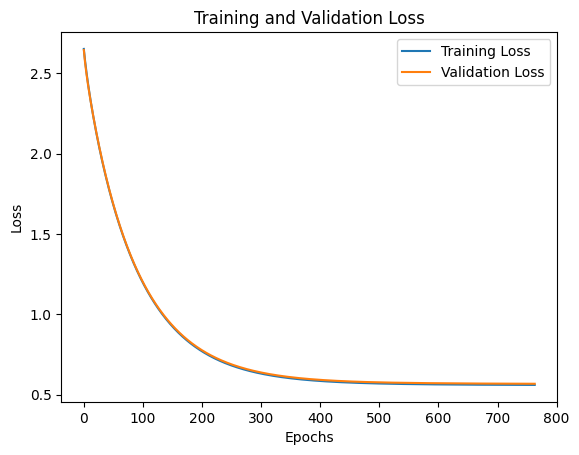

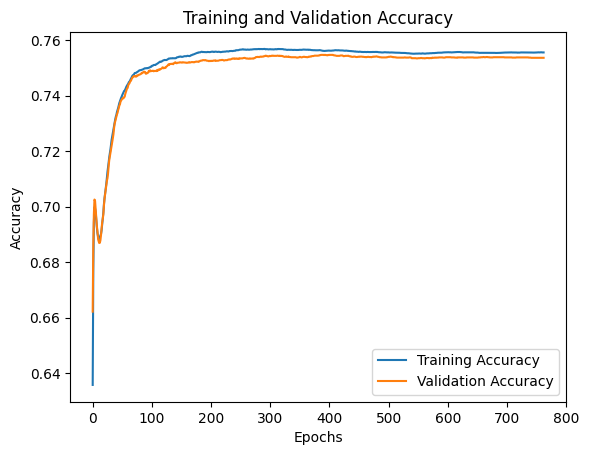

In [20]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

#plt.savefig('./img/Advanced Classification/NN1_loss.png', dpi=300, bbox_inches='tight')

plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'][1:], label='Training Accuracy')
plt.plot(history.history['val_accuracy'][1:], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#plt.savefig('./img/Advanced Classification/NN1_accuracy.png', dpi=300, bbox_inches='tight')


In [21]:
#### Performances
y_pred = nn.predict(X_test_scaled)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)

plt.show()

556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     16242
           1       0.22      0.74      0.34      1545

    accuracy                           0.75     17787
   macro avg       0.59      0.75      0.59     17787
weighted avg       0.90      0.75      0.80     17787



## NN #1

In [20]:
nn = my_nn(hidden_layers=[32, 64, 32],
           activation='relu',
           lr=0.001,
           reg_type=regularizers.l2,
           reg_penalty=0.01,
           momentum=0.9,
           )

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, verbose=True)
mc = callbacks.ModelCheckpoint('best_model_NOREG.keras', monitor='val_loss', save_best_only=True)

tf.random.set_seed(1)
# Calculate class weights
class_weight = {0: (1/np.sum(y_train == 0)) * len(y_train) / 2.0,
                 1: (1/np.sum(y_train == 1)) * len(y_train) / 2.0}

history = nn.fit(X_train_scaled,
       y_train,
       epochs=1000,
       batch_size=2048,
       shuffle=True,
       class_weight=class_weight,
       validation_data=(X_val_scaled, y_val),
       callbacks=[es, mc])

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9129 - loss: 1.7829 - val_accuracy: 0.9084 - val_loss: 1.6202
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9007 - loss: 1.7336 - val_accuracy: 0.8561 - val_loss: 1.6357
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8389 - loss: 1.6990 - val_accuracy: 0.7786 - val_loss: 1.6384
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7652 - loss: 1.6751 - val_accuracy: 0.7254 - val_loss: 1.6338
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7139 - loss: 1.6552 - val_accuracy: 0.6885 - val_loss: 1.6253
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6839 - loss: 1.6369 - val_accuracy: 0.6675 - val_loss: 1.6147
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6649 - loss: 1.6194 - val_accuracy: 0.6564 - val_loss: 1.6028
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6533 - loss: 1.6024 - val_accuracy: 0

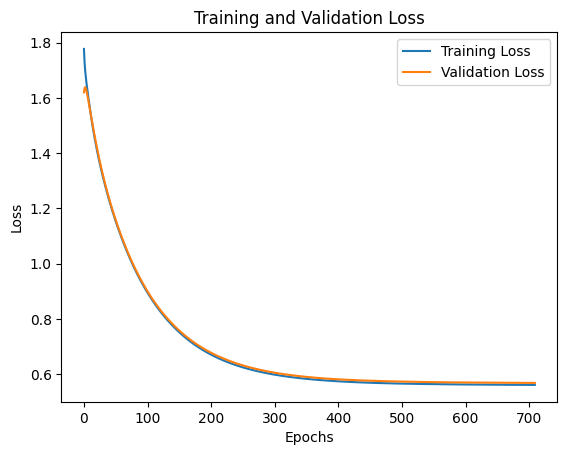

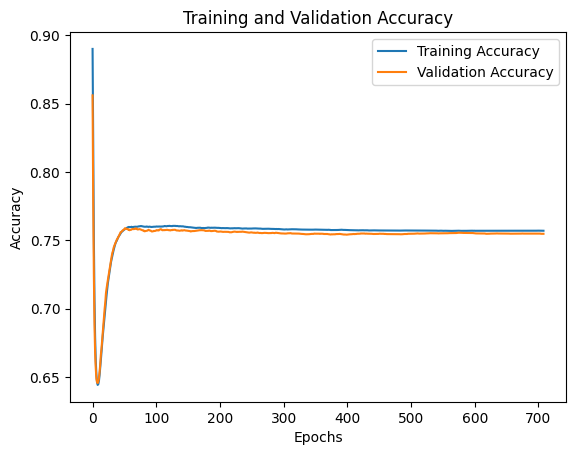

In [21]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

#plt.savefig('./img/Advanced Classification/NN1_loss.png', dpi=300, bbox_inches='tight')

plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'][1:], label='Training Accuracy')
plt.plot(history.history['val_accuracy'][1:], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#plt.savefig('./img/Advanced Classification/NN1_accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

#### Performances

In [26]:
y_pred = nn.predict(X_test_scaled)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     16242
           1       0.22      0.74      0.34      1545

    accuracy                           0.75     17787
   macro avg       0.60      0.75      0.59     17787
weighted avg       0.90      0.75      0.80     17787



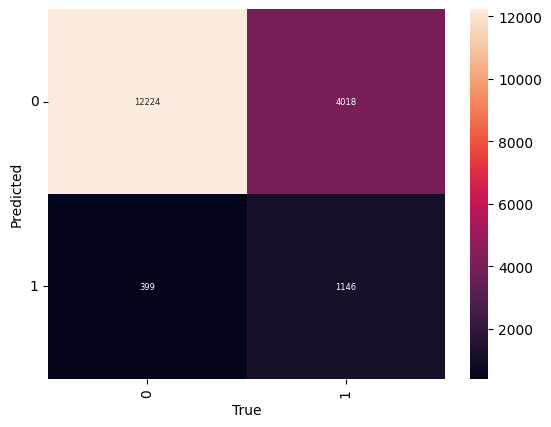

In [27]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

#plt.savefig('./img/Advanced Classification/NN1_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/dt/1fn71bpx79xgdp8ds17s_9f40000gn/T/ipykernel_43931/277916689.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


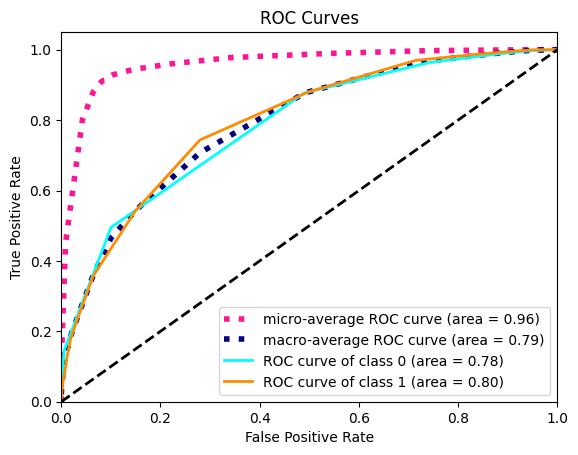

In [ ]:

from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

plt.savefig('./img/Advanced Classification/NN1_ROC.png', dpi=300, bbox_inches='tight')

plt.show()

## NN #2

In [8]:
nn = my_nn(hidden_layers=[4, 8],
           activation='relu',
           lr=0.01,
           reg_type=regularizers.l1,
           reg_penalty=0.01,
           momentum=0.9,
           )

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, verbose=True)
mc = callbacks.ModelCheckpoint('best_model_NOREG.keras', monitor='val_loss', save_best_only=True)

tf.random.set_seed(1)
# Calculate class weights
class_weight = {0: (1/np.sum(y_train == 0)) * len(y_train) / 2.0,
                 1: (1/np.sum(y_train == 1)) * len(y_train) / 2.0}

history = nn.fit(X_train_scaled,
       y_train,
       epochs=500,
       batch_size=2048,
       shuffle=True,
       class_weight=class_weight,
       validation_data=(X_val_scaled, y_val),
       callbacks=[es, mc])

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3009 - loss: 1.1363 - val_accuracy: 0.7732 - val_loss: 0.9625
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8258 - loss: 0.9936 - val_accuracy: 0.8529 - val_loss: 0.9193
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7805 - loss: 0.9468 - val_accuracy: 0.6590 - val_loss: 0.9083
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6506 - loss: 0.9144 - val_accuracy: 0.6443 - val_loss: 0.8833
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6428 - loss: 0.8846 - val_accuracy: 0.6630 - val_loss: 0.8567
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6704 - loss: 0.8530 - val_accuracy: 0.6750 - val_loss: 0.8187
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6801 - loss: 0.8107 - val_accuracy: 0.6758 - val_loss: 0.7736
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6805 - loss: 0.7622 - val_accuracy: 0.6943 - 

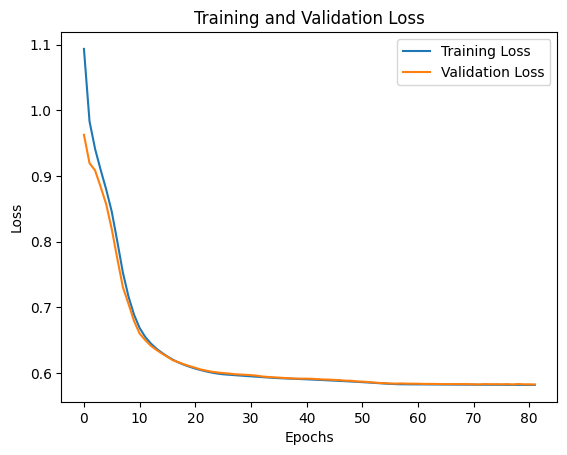

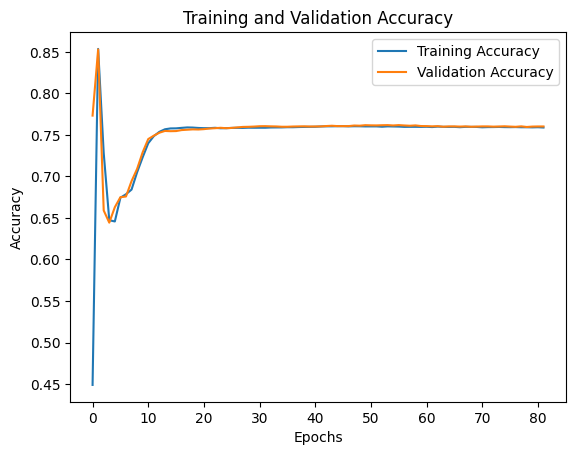

In [9]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

#plt.savefig('./img/Advanced Classification/NN2_loss.png', dpi=300, bbox_inches='tight')

plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#plt.savefig('./img/Advanced Classification/NN2_accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

#### Performances

In [10]:
y_pred = nn.predict(X_test_scaled)
y_pred = np.round(y_pred)

556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     16242
           1       0.23      0.74      0.35      1545

    accuracy                           0.76     17787
   macro avg       0.60      0.75      0.60     17787
weighted avg       0.90      0.76      0.81     17787



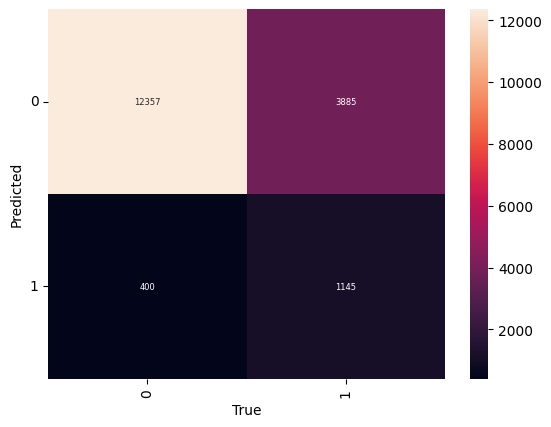

In [12]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

#plt.savefig('./img/Advanced Classification/NN2_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

In [13]:

from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

#plt.savefig('./img/Advanced Classification/NN2_ROC.png', dpi=300, bbox_inches='tight')

plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Ensemble Methods

In [ ]:
X = df.drop(columns=['id',
                     'name',
                     'artists',
                     'album_name',
                     'album_release_date',
                     'explicit',
                     'album_type',
                     'album_release_date_precision',
                     'genre'
                    ])

X_train, X_test, y_train, y_test = train_test_split(X.values,
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [ ]:
# Calculate class weights
class_weight = {0: (1/np.sum(y_train == 0)) * len(y_train),
                1: (1/np.sum(y_train == 1)) * len(y_train)}

sample_weight = np.array([class_weight[y] for y in y_train])

## Random Forest

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt','log2', None],
    'criterion': ['gini','entropy'],
    'min_samples_split':[2,4,8,16,32],
}


# Set up a 4-fold GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=4,
                           n_jobs=-1,  # Use all available cores
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

rand_forest = grid_search.best_params_

In [23]:
rand_forest=RandomForestClassifier(max_depth=30, 
                                   max_features= None, 
                                   n_estimators= 300, 
                                   min_samples_split=4,
                                  criterion='entropy')

rand_forest.fit(X_train, y_train, sample_weight=sample_weight)

RandomForestClassifier(criterion='entropy', max_depth=30, max_features=None,
                       min_samples_split=4, n_estimators=300)

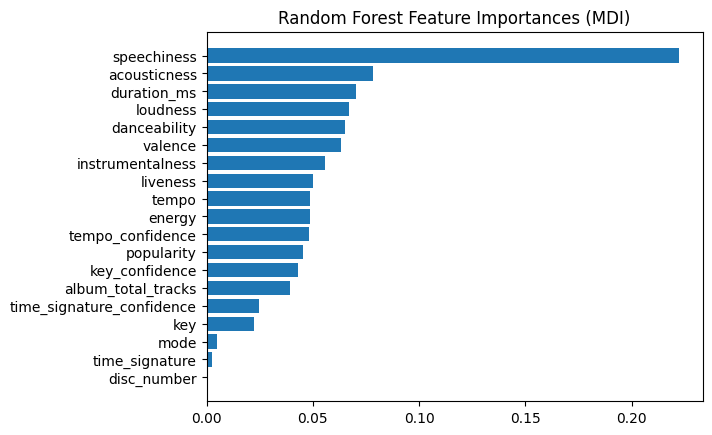

In [24]:
nbr_features = len(X.columns)

tree_feature_importances = rand_forest.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(X.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")

plt.savefig('./img/Advanced Classification/random_forest_feature_importance.png', dpi=300, bbox_inches='tight')

plt.show()

#### Performances

In [28]:
y_pred = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16242
           1       0.73      0.25      0.37      1545

    accuracy                           0.93     17787
   macro avg       0.83      0.62      0.67     17787
weighted avg       0.91      0.93      0.91     17787



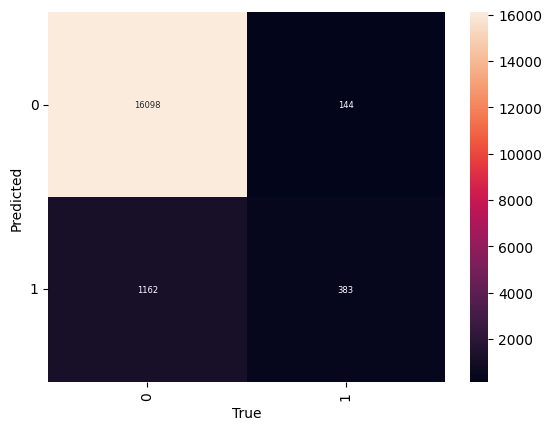

In [29]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/Advanced Classification/rand_forest_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

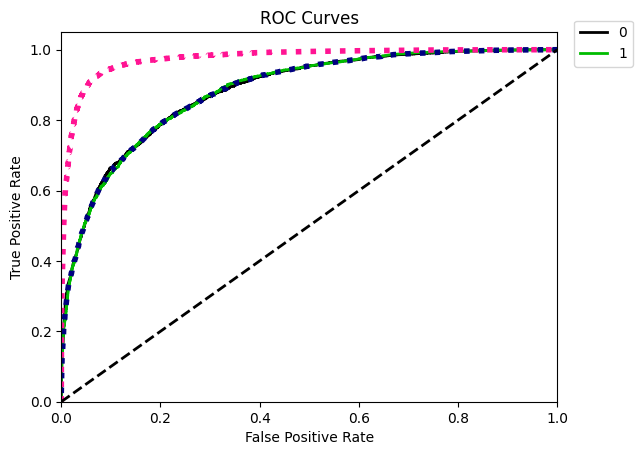

In [30]:
y_test_pred_proba = rand_forest.predict_proba(X_test) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/Advanced Classification/rand_forest_roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()

## Boosting

In [ ]:
%time
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 10],
    'algorithm':['SAMME']
}

# Set up a 4-fold GridSearchCV
grid_search = GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=4,
                           n_jobs=-1,  # Use all available cores
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

ada_boost = grid_search.best_params_

In [37]:
ada_boost=AdaBoostClassifier(algorithm='SAMME', 
                            learning_rate= 1, 
                            n_estimators= 200
                            )

ada_boost.fit(X_train, y_train, sample_weight=sample_weight)

AdaBoostClassifier(algorithm='SAMME', learning_rate=1, n_estimators=200)

#### Performances

In [38]:
y_pred = ada_boost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     16242
           1       0.23      0.75      0.35      1545

    accuracy                           0.76     17787
   macro avg       0.60      0.76      0.60     17787
weighted avg       0.91      0.76      0.81     17787



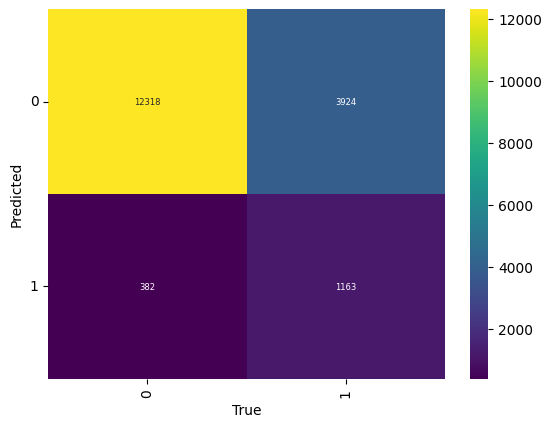

In [39]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="viridis", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/Advanced Classification/ada_boost_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

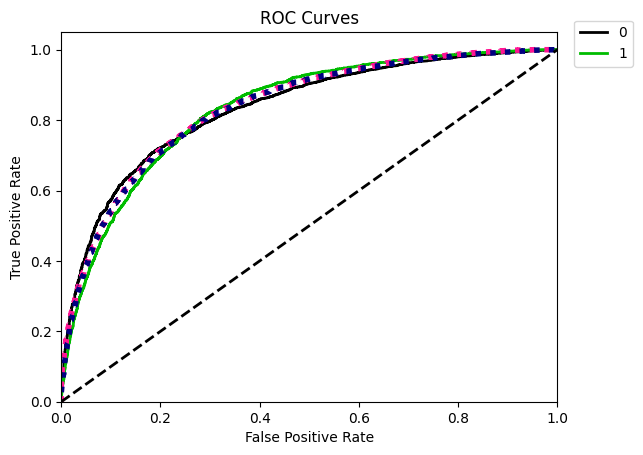

In [40]:
y_test_pred_proba = ada_boost.predict_proba(X_test) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/Advanced Classification/ada_boost_roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()

## Bagging

In [ ]:
param_grid = {
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [50, 100, 150, 200],
}

# Set up a 4-fold GridSearchCV
grid_search = GridSearchCV(estimator=BaggingClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=4,
                           n_jobs=-1,  # Use all available cores
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

bag_clf = grid_search.best_params_

In [41]:
bag_clf=BaggingClassifier(max_features=1.0,
                          max_samples=1.0,
                          n_estimators= 200
                            )  
                            
bag_clf.fit(X_train, y_train, sample_weight=sample_weight)

BaggingClassifier(n_estimators=200)

#### Performances

In [42]:
y_pred = bag_clf.predict(X_test)
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16242
           1       0.75      0.23      0.35      1545

    accuracy                           0.93     17787
   macro avg       0.84      0.61      0.66     17787
weighted avg       0.92      0.93      0.91     17787



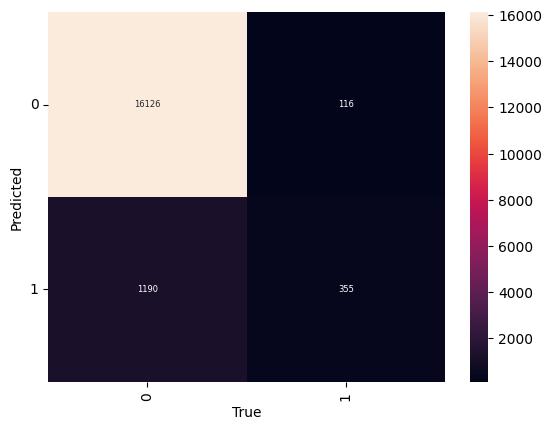

In [45]:
ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/Advanced Classification/bagging_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

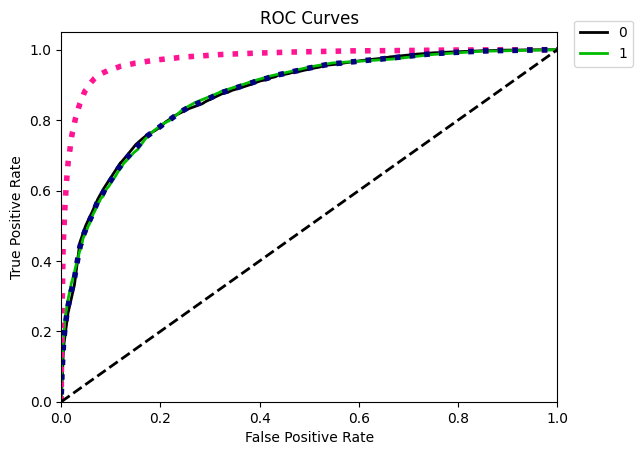

In [46]:
y_test_pred_proba = bag_clf.predict_proba(X_test) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/Advanced Classification/bagging_roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()

# Gradient Boosting

In [4]:
X = df.drop(columns=['id',
                     'name',
                     'artists',
                     'album_name',
                     'album_release_date',
                     'explicit',
                     'album_type',
                     'album_release_date_precision',
                     'genre'
                    ])

X_train, X_test, y_train, y_test = train_test_split(X.values,
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [5]:
# Calculate class weights
class_weight = {0: (1/np.sum(y_train == 0)) * len(y_train),
                1: (1/np.sum(y_train == 1)) * len(y_train)}

sample_weight = np.array([class_weight[y] for y in y_train])

## sklearn Gradient Boosting

In [9]:
%%time

param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = RandomizedSearchCV(
    GradientBoostingClassifier(),
    param_distributions=param_grid,
    cv=KFold(n_splits=4, shuffle=True, random_state=0),
    n_iter=25,
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_train, y_train, sample_weight=sample_weight)
GBClassifier = grid_search.best_estimator_

Fitting 4 folds for each of 25 candidates, totalling 100 fits
CPU times: user 13min 1s, sys: 9.2 s, total: 13min 11s
Wall time: 1h 30min 57s


In [11]:
GBClassifier.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [6]:
GBClassifier = GradientBoostingClassifier(learning_rate=0.01, max_depth=7, min_samples_split=2, min_samples_leaf=1, n_estimators=1000)
GBClassifier.fit(X_train, y_train, sample_weight=sample_weight)

GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=1000)

#### Performances

In [7]:
y_pred = GBClassifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     16242
           1       0.30      0.73      0.42      1545

    accuracy                           0.83     17787
   macro avg       0.63      0.78      0.66     17787
weighted avg       0.91      0.83      0.86     17787



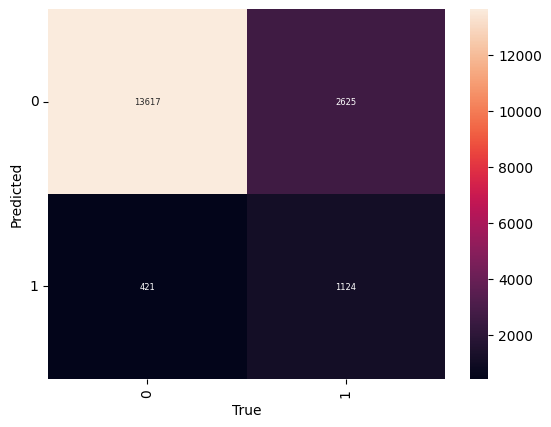

In [57]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/Advanced Classification/GB_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

0.8695273630353844


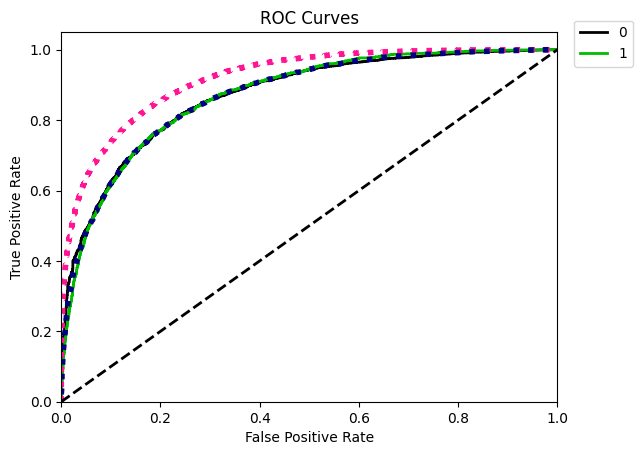

In [10]:
y_test_pred_proba = GBClassifier.predict_proba(X_test) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

#plt.savefig('./img/Advanced Classification/GB_ROC.png', dpi=300, bbox_inches='tight')
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_test, y_test_pred_proba[:, 1])
print(auroc)
plt.show()

## XGBoost

In [22]:
%%time

param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0.1, 0.01, 0.001],
    'reg_lambda': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'max_leaves': [0, 32, 64],
    'n_jobs': [-1],
    'use_label_encoder': [False],
}

grid_search = RandomizedSearchCV(
    XGBClassifier(),
    param_distributions=param_grid,
    cv=KFold(n_splits=4, shuffle=True, random_state=0),
    n_iter=600,
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_train, y_train, sample_weight=sample_weight)
XGB = grid_search.best_estimator_

Fitting 4 folds for each of 600 candidates, totalling 2400 fits


CPU times: user 1min 2s, sys: 7.99 s, total: 1min 10s
Wall time: 45min 2s


In [24]:
XGB.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.1,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': 0,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

In [11]:
XGB = XGBClassifier(objective='binary:logistic', use_label_encoder=False, n_jobs=-1, gamma=0.1, learning_rate=0.1, max_depth=7, max_leaves=0, reg_alpha=0.01, reg_lambda=0.01, n_estimators=1000)
XGB.fit(X_train, y_train, sample_weight=sample_weight)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

#### Performances

In [12]:
y_pred = XGB.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     16242
           1       0.51      0.45      0.48      1545

    accuracy                           0.91     17787
   macro avg       0.73      0.70      0.72     17787
weighted avg       0.91      0.91      0.91     17787



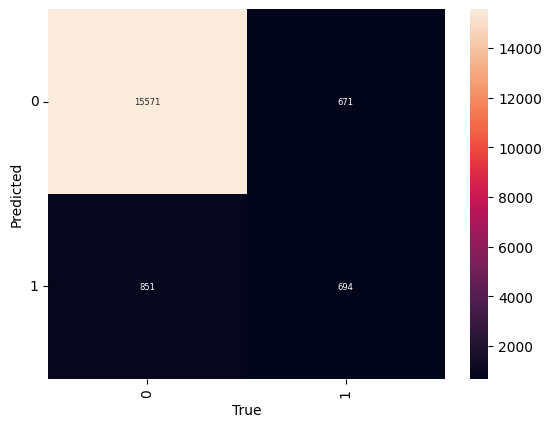

In [13]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

#plt.savefig('./img/Advanced Classification/XGB_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

0.8634129463387303


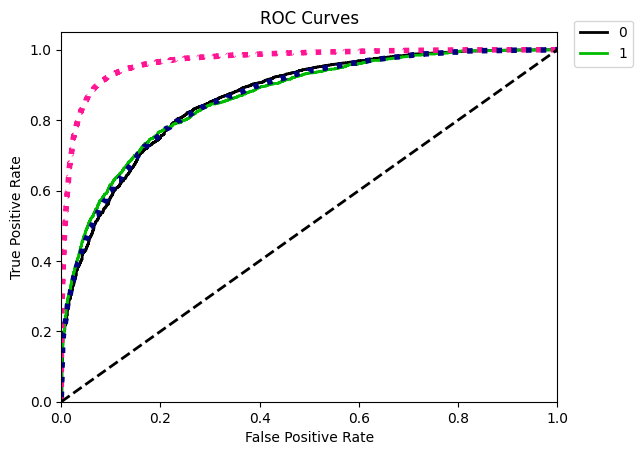

In [14]:
y_test_pred_proba = XGB.predict_proba(X_test) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

#plt.savefig('./img/Advanced Classification/XGB_ROC.png', dpi=300, bbox_inches='tight')
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_test, y_test_pred_proba[:, 1])
print(auroc)

plt.show()

## LightGBM

In [ ]:
%%time

param_grid = {
    'boosting_type': ['gbdt', 'dart', 'rf'],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'reg_alpha': [0.1, 0.01, 0.001],
    'reg_lambda': [0.1, 0.01, 0.001],
    'max_leaves': [31, 63, 127],
    'max_depth': [-1, 3, 5, 7],
    'n_jobs': [-1],
    'verbose': [-1],
}

grid_search = RandomizedSearchCV(
    LGBMClassifier(),
    param_distributions=param_grid,
    cv=KFold(n_splits=4, shuffle=True, random_state=0),
    n_iter=25,
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_train, y_train, sample_weight=sample_weight)
LGBM = grid_search.best_estimator_

In [72]:
LGBM.get_params()

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1,
 'max_leaves': 63}

In [63]:
LGBM = LGBMClassifier(boosting_type='dart', n_estimators=1000, learning_rate=0.1, reg_alpha=0.01, reg_lambda=0.01, max_depth=-1, n_jobs=-1)
LGBM.fit(X_train, y_train, sample_weight=sample_weight)

[LightGBM] [Info] Number of positive: 6180, number of negative: 64967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3531
[LightGBM] [Info] Number of data points in the train set: 71147, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(boosting_type='dart', n_estimators=1000, n_jobs=-1,
               reg_alpha=0.01, reg_lambda=0.01)

#### Performances

In [64]:
y_pred = LGBM.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     16242
           1       0.32      0.72      0.44      1545

    accuracy                           0.84     17787
   macro avg       0.65      0.79      0.68     17787
weighted avg       0.91      0.84      0.87     17787



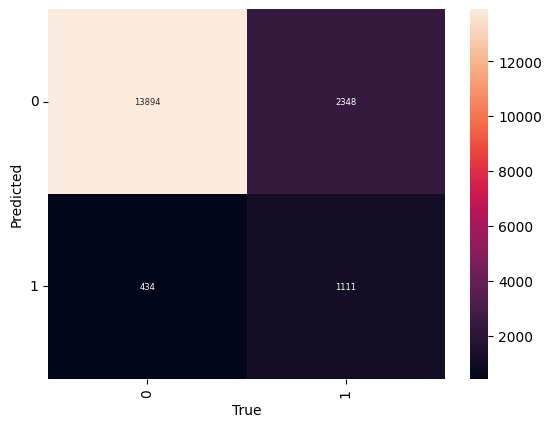

In [65]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/Advanced Classification/LGBM_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

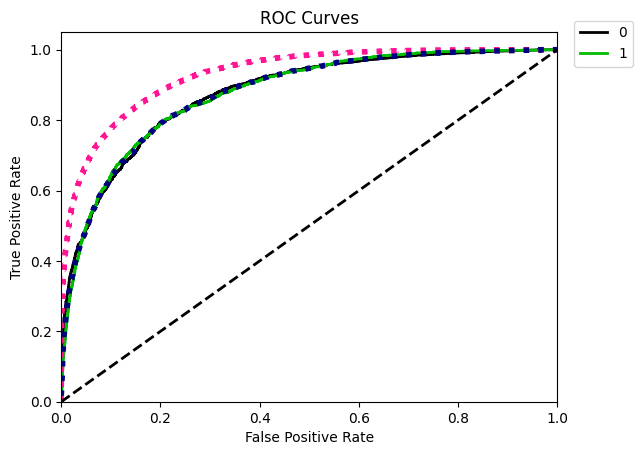

In [66]:
y_test_pred_proba = LGBM.predict_proba(X_test) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/Advanced Classification/LGBM_ROC.png', dpi=300, bbox_inches='tight')

plt.show()